# 基于计数方法

### 自然语言处理

In [2]:
text = 'You say goodbye and I say hello.'
text = text.lower()
text = text.replace('.', ' .')
print(text)
words = text.split(' ')
print(words)

you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [ ]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [ ]:
# 单词列表→数字列表
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [5]:
# 语料库预处理
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [6]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 共现矩阵

In [ ]:
# 分布式假设：某个单词的含义由它周围的单词形成
# 共现矩阵：汇总所有单词的共现单词的表格的每行对应相应的单词的向量
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32) # 方阵
    
    # 同时取到位置和元素
    # idx作为左右窗口单词的位置
    # word_id作为行索引

    for idx,word_id in enumerate(corpus):
        # 遍历窗口范围
        for i in range(1, window_size + 1):
            left_idx = idx - 1  # 计算词左侧第i个索引
            right_idx = idx + 1 # 计算词右侧第i个索引

            # 左边界条件判断
            if left_idx >= 0:
                left_word_id = corpus[left_idx]  # 取左侧单词id
                co_matrix[word_id, left_word_id] += 1 # 共现次数+1
            # 右边界条件判断
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx] # 取右侧单词id
                co_matrix[word_id, right_word_id] += 1 # 共现次数+1

    return co_matrix

### 余弦相似度公式
$$
\text{similarity}(x, y) = \frac{x \cdot y}{\|x\| \|y\|} = \frac{x_1y_1 + \dots + x_ny_n}{\sqrt{x_1^2 + \dots + x_n^2}\sqrt{y_1^2 + \dots + y_n^2}}
$$

In [ ]:
# 余弦相似度公式
def cos_similarity(x, y):
    nx = x / np.sqrt(np.sum(x ** 2))
    ny = y / np.sqrt(np.sum(y ** 2))
    return np.dot(nx, ny)

# 当零向量被赋值给参数时，会出现除数为0错误
# 一般在执行除法时给分母一个微小值，通过向量范数将其吸收，大多数情况不会影响计算
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [ ]:
# 尝试求 you 和 i 的相似度
import sys
sys.path.append('./res')
from common.util import preprocess, create_co_matrix, cos_similarity
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


In [5]:

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 取出查询词
    if query not in word_to_id:
        print('%s is not found' % query) # 词不存在则打印提示
        return
        # 查询词是否在词汇表中(防止KeyError报错)


    print('\n[query]'+query) # 标注当前查询词
    query_id = word_to_id[query] # 将查询词转换为数字id
    query_vec = word_matrix[query_id] # 根据id，从词向量矩阵中取出查询词对应向量

    # 计算余弦相似度
    vocab_size = len(id_to_word) # 获取词汇表中总词汇数
    similarity = np.zeros(vocab_size) # 初始化全零数组
    for i in range(vocab_size): # 遍历所有词汇id 
        similarity[i] = cos_similarity(word_matrix[i], query_vec) # 逐个计算 当前词向量 & 查询词向量 余弦相似度
 
    # 基于余弦相似度，按降序输出值
    count = 0
    for i in (-1 * similarity).argsort():
        ''' 
        (-1 * similarity).argsort()等价于np.argsort(-1 * similarity)
        np.argsort(数组)→数组对象.argsort():返回数组升序后排序的【索引值】
        -1  * similarity :大值变负值更小、小值变负值更大，再利用升序，等价于原数组降序排序
        '''

        # 跳过查询自身
        if id_to_word[i] == query:
            continue

        # 格式化输出——词汇名:对应余弦相似度
        print(' %s:%s' % (id_to_word[i], similarity[i]))

        # 计数+1
        count += 1

        # 只计算前top个相似词
        if count >= top:
            return

In [6]:
import sys
sys.path.append('./res')
from common.util import preprocess, create_co_matrix, most_similar
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 hello: 0.7071067691154799
 i: 0.7071067691154799
 and: 0.0
 say: 0.0


### 点互信息（PMI）
$$
\text{PMI}(x, y) = \log_2 \frac{P(x, y)}{P(x)P(y)}
$$

$$\text{PMI}(x,y) = \log_2 \frac{P(x,y)}{P(x)P(y)} = \log_2 \frac{\frac{C(x,y)}{N}}{\frac{C(x)}{N}\frac{C(y)}{N}} = \log_2 \frac{C(x,y) \cdot N}{C(x)C(y)} \tag{2.3}$$

$$\text{PPMI}(x,y) = \max(0, \text{PMI}(x,y)) \tag{2.6}$$

In [ ]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100+1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [12]:
import sys
sys.path.append('./res')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) # 有效数字为3
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 基于SVD的降维

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01 -1.110e-16 -4.441e-16 -1.205e-01  0.000e+00 -9.323e-01
 -1.086e-16]
[ 3.409e-01 -1.110e-16]


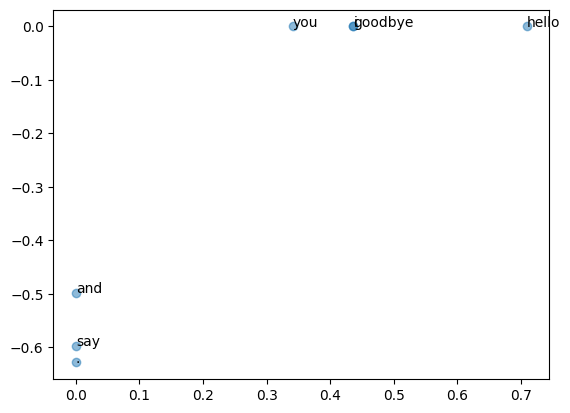

In [17]:
import sys
sys.path.append('./res')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

print(C[0]) # 共现矩阵
print(W[0]) # PPMI矩阵
print(U[0]) # SVD

print(U[0,:2])

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

### 使用更大的PTB数据集

In [19]:
import sys
sys.path.append('./res')
from dataset import ptb
corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

URLError: <urlopen error [WinError 10061] 由于目标计算机积极拒绝，无法连接。>